In [1]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from script.plotDisplay import plotDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
mlp_model = ctypes.CDLL("modele/mlp/target/release/libmlp_classification.so")

# Définir les types d'arguments et de retour des fonctions C
PROGRESS_CALLBACK = ctypes.CFUNCTYPE(None, ctypes.c_int, ctypes.c_double)
mlp_model.mlpInit.argtypes = [ctypes.POINTER(ctypes.c_size_t), ctypes.c_size_t, ctypes.c_double]
mlp_model.mlpInit.restype = ctypes.c_void_p

mlp_model.mlpTrain.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_bool,
    PROGRESS_CALLBACK,
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.c_char_p  
]
mlp_model.mlpTrain.restype = None


mlp_model.mlpPredict.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.POINTER(ctypes.c_double)
]
mlp_model.mlpPredict.restype = None

mlp_model.mlpFree.argtypes = [ctypes.c_void_p]
mlp_model.mlpFree.restype = None


# First test case

In [3]:
parameter = np.array([2, 1], dtype=np.uintp)
learning_rate = 0.1
epochs = 1000000
batch_size = 1
classification = True
callback_interval = 1000
checkpoint_enable = False
checkpoint_interval = 1000
log_enable = False
log_tag = "simpleTestCase".encode('utf-8')

# tensorboard_dir = "./log/"
parameter_ptr = parameter.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, parameter.size, learning_rate)

X_train = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0]
], dtype=np.float64)

y_train = np.array([
    [1.0],
    [-1.0],
    [1.0]
], dtype=np.float64)

print(f'vecteur {X_train}')
print(f'vecteur {X_train.shape}')

layer : 1
vecteur [[0. 0.]
 [0. 1.]
 [1. 0.]]
vecteur (3, 2)
neural matrix : [NeuralMatrix { matrix: [[0.3068132275429156, 0.8036619751791556]], bias: [0.0], input_size: 2, output_size: 1 }]


In [4]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs,
    batch_size,
    classification,
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Sample [0. 0.] , predictions = [0.99996543]
Sample [0. 1.] , predictions = [-0.99997624]
Sample [1. 0.] , predictions = [0.99999894]
ndim = 1


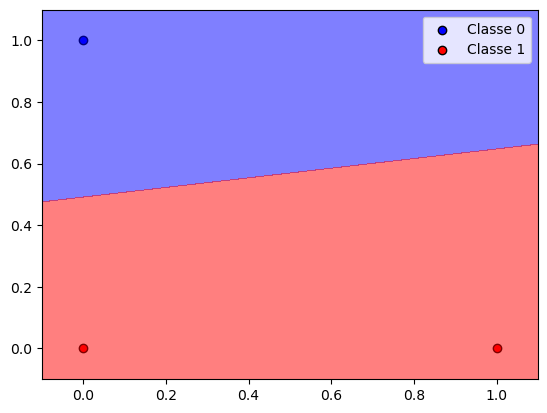

In [5]:
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)


plotDisplay(X_train, y_train, nn, mlp_model)


mlp_model.mlpFree(nn)

# Xor test case

In [37]:
X_train = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0]
], dtype=np.float64)

y_train = np.array([
    [-1.0],
    [1.0],
    [1.0],
    [-1.0]
], dtype=np.float64)

neurons_size = np.array([X_train.shape[1], 4, y_train.shape[1]], dtype=np.uintp)
learning_rate = 0.01
epochs = 1000000
batch_size = 1
classification = True
callback_interval = 1000
checkpoint_enable = False
checkpoint_interval = 1000
log_enable = False
log_tag = "xorTestCase".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

print(f'shape {X_train.shape}')
print(f'shape {y_train.shape}')
print(f'vecteur {X_train}')
print(f'vecteur {y_train}')

layer : 2
neural matrix : [NeuralMatrix { matrix: [[0.8968813713326345, 0.2115615291223114], [-0.41716553538591805, 0.20144809688100862], [0.7483441557986144, 0.8498182024591174], [-0.25334839939987797, 0.0805476276508501]], bias: [0.0, 0.0, 0.0, 0.0], input_size: 2, output_size: 4 }, NeuralMatrix { matrix: [[-0.7645045862541502, 0.10357661597936874, 0.5302055496620226, 0.5779716672686366]], bias: [0.0], input_size: 4, output_size: 1 }]
shape (4, 2)
shape (4, 1)
vecteur [[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
vecteur [[-1.]
 [ 1.]
 [ 1.]
 [-1.]]


In [38]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs,
    batch_size,
    classification, 
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Sample [0. 0.] , predictions = [-0.99984962]
Sample [0. 1.] , predictions = [0.99984726]
Sample [1. 0.] , predictions = [0.99985508]
Sample [1. 1.] , predictions = [-0.99985493]
ndim = 1


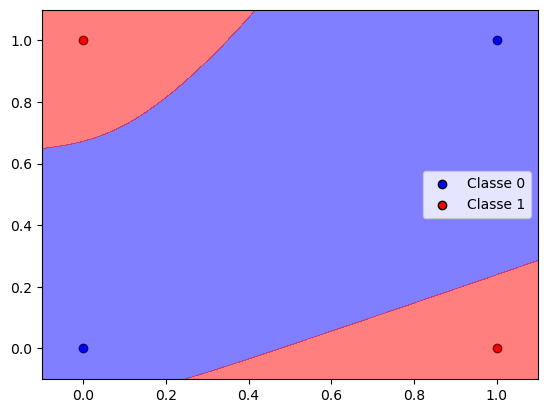

In [39]:
predictions = []
for k in range(len(X_train)):
    prediction = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        prediction.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    predictions.append(prediction.tolist())
    print("Sample", X_train[k], ", predictions =", prediction)


plotDisplay(X_train, y_train, nn, mlp_model)

mlp_model.mlpFree(nn)

# Multi class test

In [9]:
X_train = np.array([
    [1.0, 1.0],  # Classe A
    [5.0, 5.0],  # Classe B
    [0, 3.0] 
], dtype=np.float64)

y_train = np.array([
    [1.0, 0.0, 0.0],  # Classe A
    [0.0, 1.0, 0.0],  # Classe B
    [0.0, 0.0, 1.0]   # Classe C
], dtype=np.float64)

neurons_size = np.array([X_train.shape[1], y_train.shape[1]], dtype=np.uintp)
learning_rate = 0.01
epochs = 1000000
batch_size = 1
classification = True
callback_interval = 1000
checkpoint_enable = False
checkpoint_interval = 1000
log_enable = False
log_tag = "simpleMultiTestCase".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

print(f"shape : {X_train.shape}")
print(f"shape : {y_train.shape}")

shape : (3, 2)
shape : (3, 3)
layer : 1
neural matrix : [NeuralMatrix { matrix: [[-0.5908062953411637, 0.24992501795612476], [-0.7339539666290307, -0.848116010893782], [-0.34145924491222956, 0.4273857535627621]], bias: [0.0, 0.0, 0.0], input_size: 2, output_size: 3 }]


In [10]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs,
    batch_size,
    classification,  
    callback_func,
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Sample [1. 1.] , predictions = [0.99125332 0.00554674 0.00319994]
Sample [5. 5.] , predictions = [3.27127918e-03 9.96724880e-01 3.84036809e-06]
Sample [0. 3.] , predictions = [2.97058400e-03 7.25957376e-04 9.96303459e-01]
ndim = multi


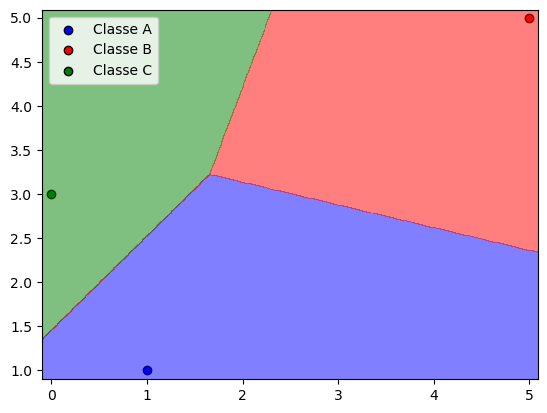

In [11]:
for k in range(len(X_train)):
    predictions = np.zeros(3, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)
    

plotDisplay(X_train, y_train, nn, mlp_model)

mlp_model.mlpFree(nn)

# Multi class 

In [12]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1.0, 0.0, 0.0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else
                [0.0, 1.0, 0.0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else
                [0.0, 0.0, 1.0] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else
                [0, 0, 0] for p in X], dtype=np.float64)

X_train = X[[not np.all(arr == [0, 0, 0]) for arr in Y]]
y_train = Y[[not np.all(arr == [0, 0, 0]) for arr in Y]]

neurons_size = np.array([2, y_train.shape[1]], dtype=np.uintp)
learning_rate = 0.1
epochs = 100000
callback_interval = 1000
checkpoint_enable = False
checkpoint_interval = 1000
log_enable = False
log_tag = "MultiTestCase".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)


# print(f"{X_train}")
print(f"shape : {X_train.shape}")
print(f"shape : {y_train.shape}")

shape : (418, 2)layer : 1
neural matrix : [NeuralMatrix { matrix: [[0.7074666276942652, 0.6577234171783939], [0.7074836663227129, 0.5901891549501972], [-0.32169465075971626, 0.37167184492908456]], bias: [0.0, 0.0, 0.0], input_size: 2, output_size: 3 }]

shape : (418, 3)


In [13]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

trainResult = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs, 
    1,
    True,
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

ndim = multi


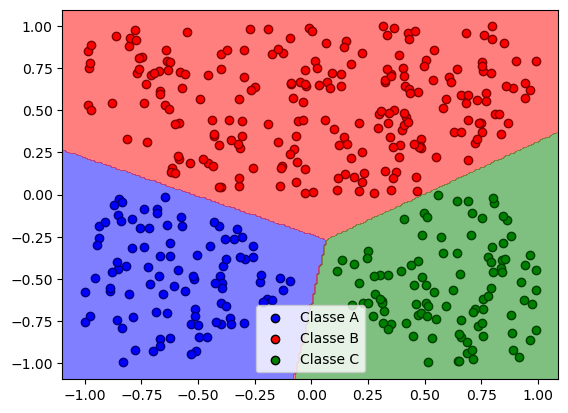

In [14]:
# for k in range(len(X_train)):
#     predictions = np.zeros(3, dtype=np.float64)
#     mlp_model.mlpPredict(
#         nn,
#         X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
#         X_train[k].size,
#         True,
#         predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
#     )
    # print("Sample", X_train[k], ", predictions =", predictions)

plotDisplay(X_train, y_train, nn, mlp_model)

mlp_model.mlpFree(nn)

## Cross entropy

In [64]:

X_train = np.random.random((500, 2)) * 2.0 - 1.0
y_train = np.array([[1.0] if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else [-1.0] for p in X_train], dtype=np.float64)

# X_train = np.random.random((500, 2)) * 2.0 - 1.0
# y_train = np.array([[1.0] if p[0] * p[0] + p[1] * p[1] <= 0.5 else [-1.0] for p in X_train], dtype=np.float64)

print(f"X_train : {X_train[:10]}")
print(f"X_train : {y_train[:10]}")

neurons_size = np.array([X_train.shape[1], 4, y_train.shape[1]], dtype=np.uintp)
learning_rate = 0.1
epochs = 1000000
batch_size = X_train.shape[0]
classification = True
callback_interval = 10000
checkpoint_enable = False
checkpoint_interval = 1000
log_enable = False
log_tag = "CrossEntropy".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)


# print(f"{X_train}")
print(f"shape : {X_train.shape}")
print(f"shape : {y_train.shape}")

X_train : [[ 0.95028452 -0.40415366]
 [-0.65846558  0.89560668]
 [-0.45615851 -0.83769163]
 [ 0.16184811 -0.42857006]
 [ 0.29179174  0.31259811]
 [-0.79874939 -0.91105975]
 [ 0.31512343 -0.19425194]
 [-0.36988807  0.11885087]
 [-0.91383823 -0.48600713]
 [ 0.06710049 -0.97490292]]
X_train : [[-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]]
shape : (500, 2)
shape : (500, 1)
layer : 2
neural matrix : [NeuralMatrix { matrix: [[-0.35866412580924134, -0.6828664277889498], [-0.8318465306697358, -0.8426697495465469], [0.8942231268248007, -0.4876384219658947], [0.6710865229498824, 0.14497724819551738]], bias: [0.0, 0.0, 0.0, 0.0], input_size: 2, output_size: 4 }, NeuralMatrix { matrix: [[0.8419528413573696, -0.44096897009346314, -0.26866943219808004, -0.761709066530118]], bias: [0.0], input_size: 4, output_size: 1 }]


In [65]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs, 
    batch_size,
    classification,
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Accuracy : 1.0
ndim = 1


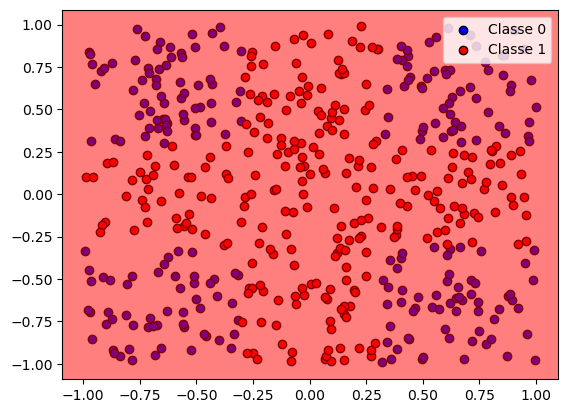

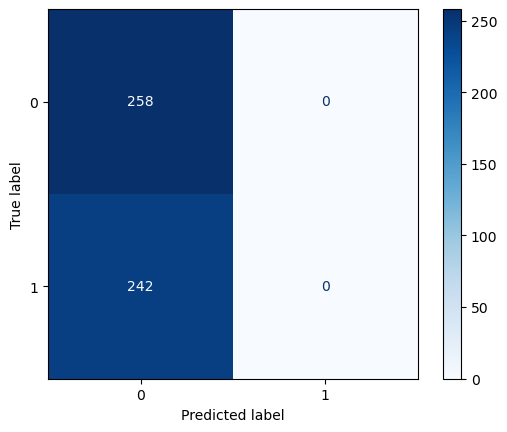

In [66]:

accurate = 0
for k in range(len(X_train)):
    predictions = np.zeros(3, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    if np.argmax(predictions) == np.argmax(y_train[k]):
        accurate += 1
    # print("Sample", X_train[k], ", predictions =", predictions)

print(f"Accuracy : {accurate / len(X_train)}")
plotDisplay(X_train, y_train, nn, mlp_model)

cm = confusion_matrix(np.argmax(X_train, axis=1), np.argmax(y_train, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


mlp_model.mlpFree(nn)

# Cross multi class

In [18]:

X_train = np.random.random((1000, 2)) * 2.0 - 1.0
y_train = np.array([
    [1.0, 0.0, 0.0] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else 
    [0.0, 1.0, 0.0] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else 
    [0.0, 0.0, 1.0] 
    for p in X_train
])


neurons_size = np.array([X_train.shape[1], 4, y_train.shape[1]], dtype=np.uintp)
learning_rate = 0.1
epochs = 100000
batch_size = 1
classification = True
callback_interval = 1000
checkpoint_enable = False
log_enable = False
log_tag = "crossLinearTestCase".encode('utf-8')

parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

# print(y_train[:10])
# print(X_train[:10])
# print(f"shape {X_train.shape}")
# print(f"shape {y_train.shape}")

# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='rbw')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.ylabel('X3')
# plt.title('Training Data Visualization')
# plt.show()


layer : 2
neural matrix : [NeuralMatrix { matrix: [[0.05143163614293256, 0.5989444662423256], [0.18526370026948324, 0.2231256050368282], [0.9909338358039883, -0.5666656556598708], [0.882360927947615, -0.3059725219885201]], bias: [0.0, 0.0, 0.0, 0.0], input_size: 2, output_size: 4 }, NeuralMatrix { matrix: [[-0.917690233541189, -0.728249413442621, -0.34649932384970095, 0.5927849051369138], [-0.3783934713821213, -0.8843893980786541, 0.11186692026083067, -0.08881105161056979], [-0.4709351219043807, 0.8133580516575512, 0.2369406328719541, 0.2600439318019996]], bias: [0.0, 0.0, 0.0], input_size: 4, output_size: 3 }]


In [19]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    y_train.shape[1],
    epochs, 
    batch_size,
    True,
    callback_func,
    callback_interval,
    checkpoint_enable,
    checkpoint_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

ndim = multi


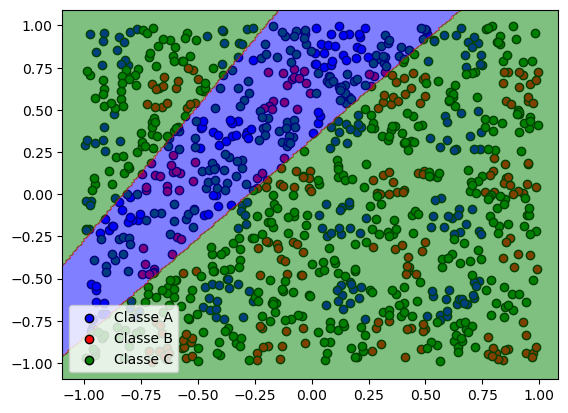

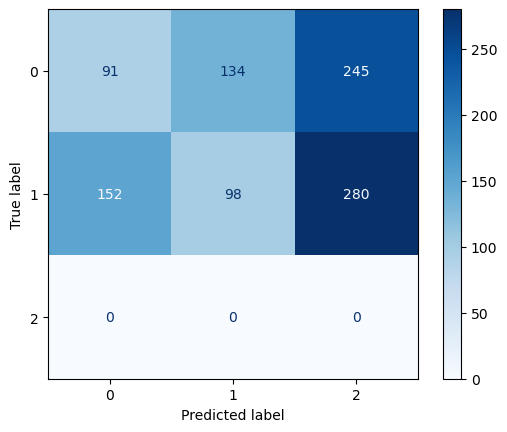

In [20]:
# for k in range(len(X_train)):
#     predictions = np.zeros(3, dtype=np.float64)
#     mlp_model.mlpPredict(
#         nn,
#         X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
#         X_train[k].size,
#         True,
#         predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
#     )
    # print("Sample", X_train[k], ", predictions =", predictions)

plotDisplay(X_train, y_train, nn, mlp_model)

cm = confusion_matrix(np.argmax(X_train, axis=1), np.argmax(y_train, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

mlp_model.mlpFree(nn)

# Simple linear test

In [21]:
neurons_size = np.array([1, 1], dtype=np.uintp)
learning_rate = 0.001
epochs = 1000000
callback_interval = 1000
checkpoint_enable = False
callback_interval = 1000
log_enable = False
log_tag = "simpleLinearTestCase".encode('utf-8')
parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [3.0],
    [7.0],
], dtype=np.float64)

y_train = np.array([
    [-3.0],
    [2.0],
], dtype=np.float64)

layer : 1
neural matrix : [NeuralMatrix { matrix: [[0.5092571202111755]], bias: [0.0], input_size: 1, output_size: 1 }]


In [22]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,
    1,
    False,
    callback_func,
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag
)
progress_bar.close()

Training Progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [23]:
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        False,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)

# plotDisplay(X_train, y_train, nn, mlp_model)
mlp_model.mlpFree(nn)

Sample [3.] , predictions = [-3.]
Sample [7.] , predictions = [2.]


# Linear test

In [24]:
neurons_size = np.array([1, 3, 1], dtype=np.uintp)
learning_rate = 0.01
epochs = 10000000
callback_interval = 10000
checkpoint_enable = False
callback_interval = 1000
log_enable = False
log_tag = "linearTestCase".encode('utf-8')
parameter_ptr = neurons_size.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))
nn = mlp_model.mlpInit(parameter_ptr, neurons_size.size, learning_rate)

X_train = np.array([
    [3.0],
    [7.0],
    [9.0],
], dtype=np.float64)

y_train = np.array([
    [8.0],
    [2.0],
    [6.0],
], dtype=np.float64)

layer : 2
neural matrix : [NeuralMatrix { matrix: [[-0.012923147011751457], [-0.6187579633718521], [0.09381359935945444]], bias: [0.0, 0.0, 0.0], input_size: 1, output_size: 3 }, NeuralMatrix { matrix: [[0.4937584458831723, -0.06549592437251484, 0.8428344072206526]], bias: [0.0], input_size: 3, output_size: 1 }]


In [25]:
progress_bar = tqdm(total=epochs, desc="Training Progress")

def progress_callback(epochs, loss):
    progress_bar.update(callback_interval)
    progress_bar.set_postfix(loss=loss)

callback_func = PROGRESS_CALLBACK(progress_callback)

loss = mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    1,
    epochs,
    16,
    False,
    callback_func,
    callback_interval,
    checkpoint_enable,
    callback_interval,
    log_enable,
    log_tag,
)
progress_bar.close()

Training Progress:   0%|          | 0/10000000 [00:00<?, ?it/s]

In [26]:
allPrediction = []
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        False,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    allPrediction.append(predictions)
    print("Sample", X_train[k], ", predictions =", predictions)

# plotDisplay(X_train, y_train, nn, mlp_model)
mlp_model.mlpFree(nn)

Sample [3.] , predictions = [5.33333333]
Sample [7.] , predictions = [5.33333333]
Sample [9.] , predictions = [5.33333333]


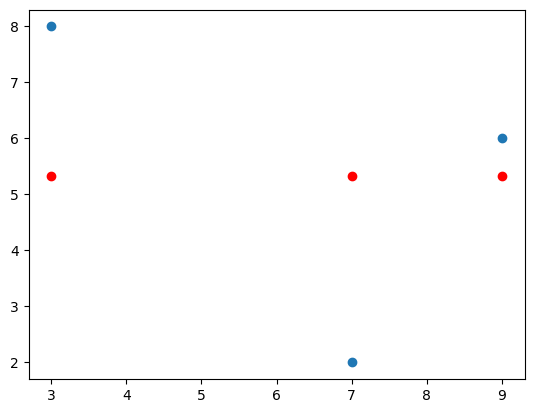

In [27]:
plt.scatter(X_train, y_train)
plt.scatter(X_train, allPrediction, c='red')
plt.show()